## Team 4

## Name:

Yu-Chih (Wisdom) Chen

Jessy Hu

Boya Zeng

Yuqing Wu

## Date:

02/20/2024



In [73]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.express as px
import squarify
import unidecode
import contractions
from tqdm import tqdm
tqdm.pandas()
from pandarallel import pandarallel
from functools import reduce
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
import random
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Ensure you have the necessary NLTK data downloaded
nltk.download('punkt')

# Download stopwords
nltk.download('stopwords')

nltk.download('wordnet')
nltk.download('words')

# Define stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /Users/boyazeng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/boyazeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/boyazeng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/boyazeng/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [74]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 8


In [75]:
pandarallel.initialize(nb_workers=num_processors-3, use_memory_fs=False, progress_bar=True)

INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## 1. Load Instacart Dataset

In [76]:
%%time
df = pd.read_csv("instacart.csv")

# Sample 50% of the data without replacement
# df = df.sample(frac=0.5, replace=False)

# Display the first 3 rows of the sampled dataframe
df.head(3)

CPU times: user 15.8 s, sys: 4.33 s, total: 20.1 s
Wall time: 21.8 s


order_id  product_id  add_to_cart_order  reordered        product_name  \
0         2       33120                  1          1  Organic Egg Whites   
1        26       33120                  5          0  Organic Egg Whites   
2       120       33120                 13          0  Organic Egg Whites   

   aisle_id  department_id  user_id eval_set  order_number  order_dow  \
0        86             16   202279    prior             3          5   
1        86             16   153404    prior             2          0   
2        86             16    23750    prior            11          6   

   order_hour_of_day  days_since_prior_order aisle  department  
0                  9                     8.0  eggs  dairy eggs  
1                 16                     7.0  eggs  dairy eggs  
2                  8                    10.0  eggs  dairy eggs

### 1.1 Structure of data

In [77]:
df_records_1 = df.shape[0]
df_fields_1 = df.shape[1]
print("There are totally %d records and %d fields in record" %(df_records_1,df_fields_1))

There are totally 32434489 records and 15 fields in record


1) There are totally 32,434,489 records and 29 fields in the dataframe

In [78]:
# All operations based on raw data will be performed on df_0
df_0 = copy.deepcopy(df)

In [79]:
df_0['order_id'] = df_0['order_id'].astype('object')
df_0['user_id'] = df_0['user_id'].astype('object')
df_0['product_id'] = df_0['product_id'].astype('object')
df_0['aisle_id'] = df_0['aisle_id'].astype('object')
df_0['department_id'] = df_0['department_id'].astype('object')

In [80]:
feature_types = set()

# Features Category Analysis
for column in tqdm(df_0.columns.values):
  print(column,"\t", df_0[column].dtype)
  feature_types.add(str(df_0[column].dtype))
print("feature type: ", feature_types)

100%|████████████████████████████████████████| 15/15 [00:00<00:00, 27223.95it/s]

order_id 	 object
product_id 	 object
add_to_cart_order 	 int64
reordered 	 int64
product_name 	 object
aisle_id 	 object
department_id 	 object
user_id 	 object
eval_set 	 object
order_number 	 int64
order_dow 	 int64
order_hour_of_day 	 int64
days_since_prior_order 	 float64
aisle 	 object
department 	 object
feature type:  {'float64', 'int64', 'object'}


In [81]:
# Check Missing Value

df_0.isnull().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
product_name                    0
aisle_id                        0
department_id                   0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
aisle                           0
department                      0
dtype: int64

In [82]:
## Observing the input data, we have missing values,
## which are not shown in the statistical analysis.
## Therefore, we replace the missing value "" with np.nan
## and re-compute the statistical data.

for column in tqdm(df_0.columns.values):
    df_0[column] = df_0[column].parallel_map(lambda x: np.nan if x == '' else x)

  0%|                                                    | 0/15 [00:00<?, ?it/s]

  7%|██▉                                         | 1/15 [00:03<00:50,  3.61s/it]

 13%|█████▊                                      | 2/15 [00:06<00:43,  3.32s/it]

 20%|████████▊                                   | 3/15 [00:09<00:35,  2.99s/it]

 27%|███████████▋                                | 4/15 [00:11<00:30,  2.78s/it]

 33%|██████████████▋                             | 5/15 [00:14<00:26,  2.68s/it]

 40%|█████████████████▌                          | 6/15 [00:16<00:23,  2.56s/it]

 47%|████████████████████▌                       | 7/15 [00:18<00:19,  2.48s/it]

 53%|███████████████████████▍                    | 8/15 [00:22<00:18,  2.70s/it]

 60%|██████████████████████████▍                 | 9/15 [00:24<00:15,  2.52s/it]

 67%|████████████████████████████▋              | 10/15 [00:26<00:11,  2.36s/it]

 73%|███████████████████████████████▌           | 11/15 [00:28<00:09,  2.27s/it]

 80%|██████████████████████████████████▍        | 12/15 [00:30<00:06,  2.22s/it]

 87%|█████████████████████████████████████▎     | 13/15 [00:32<00:04,  2.10s/it]

 93%|████████████████████████████████████████▏  | 14/15 [00:34<00:02,  2.12s/it]

100%|███████████████████████████████████████████| 15/15 [00:36<00:00,  2.45s/it]


In [83]:
df_0.isnull().sum()/df_0.shape[0]*100

order_id                  0.00000
product_id                0.00000
add_to_cart_order         0.00000
reordered                 0.00000
product_name              0.00000
aisle_id                  0.00000
department_id             0.00000
user_id                   0.00000
eval_set                  0.00000
order_number              0.00000
order_dow                 0.00000
order_hour_of_day         0.00000
days_since_prior_order    6.40697
aisle                     0.00000
department                0.00000
dtype: float64

We can classify the features into **float64**, **object** and **int** according to the dtype of the column elements.

In [84]:
# Feature Statistical Analysis
float_feat = []
object_feat = []
int_feat = []

for column in tqdm(df_0.columns.values):
  if df_0[column].dtype == "float64":
    float_feat.append(column)
  elif df_0[column].dtype == "object":
    object_feat.append(column)
  else:
    int_feat.append(column)

100%|████████████████████████████████████████| 15/15 [00:00<00:00, 67942.29it/s]


In [85]:
float_feat

['days_since_prior_order']

In [86]:
object_feat

['product_name', 'eval_set', 'aisle', 'department']

In [87]:
int_feat

['order_id',
 'product_id',
 'add_to_cart_order',
 'reordered',
 'aisle_id',
 'department_id',
 'user_id',
 'order_number',
 'order_dow',
 'order_hour_of_day']

Based on specific meanings of the features, we could divide the features into 'numerical', 'categorical' and 'empty' features:

1. **Numerical features**: order_dow, order_hour_of_day, days_since_prior, reordered

2. **Categorical features**:

*   **Nominal features**: order_id, user_id, eval_set, product_id, product_name, aisle_id, aisle, department_id, department
*   **Ordinal features**: order_number, add_to_cart_order

3. **Empty features**: days_since_prior

### 1.2 Additional basic summary statistics

#### 1.2.1 Numerical Feature Analysis

In [88]:
numerical_feat = ['order_dow', 'order_hour_of_day', 'days_since_prior_order', 'reordered']

stat_df = df_0.loc[:,numerical_feat]
stat_df.describe()

order_dow  order_hour_of_day  days_since_prior_order     reordered
count  3.243449e+07       3.243449e+07            3.035642e+07  3.243449e+07
mean   2.738818e+00       1.342498e+01            1.110407e+01  5.896975e-01
std    2.090049e+00       4.246365e+00            8.778914e+00  4.918886e-01
min    0.000000e+00       0.000000e+00            0.000000e+00  0.000000e+00
25%    1.000000e+00       1.000000e+01            5.000000e+00  0.000000e+00
50%    3.000000e+00       1.300000e+01            8.000000e+00  1.000000e+00
75%    5.000000e+00       1.600000e+01            1.500000e+01  1.000000e+00
max    6.000000e+00       2.300000e+01            3.000000e+01  1.000000e+00

#### 1.2.2 Categorical Feature Analysis

In [89]:
%%time

# Your existing code
nominal_col = ['order_id', 'user_id', 'eval_set', 
               'product_id', 'product_name', 'aisle_id', 
               'aisle', 'department_id', 'department']

df_0_null = pd.DataFrame(df_0.isnull().sum())
df_0_uni = pd.DataFrame(df_0.nunique())

dfs = [df_0_null, df_0_uni]
df_0_s = reduce(lambda df_left,df_right: pd.merge(df_left,df_right,left_index=True,right_index=True,how='outer'),dfs)
df_0_s.columns = ["Count_of_Nulls","Unique_Value"]
df_0_s.transpose().loc[:,object_feat].transpose()

CPU times: user 6.59 s, sys: 438 ms, total: 7.03 s
Wall time: 7.07 s


Count_of_Nulls  Unique_Value
product_name               0         49677
eval_set                   0             1
aisle                      0           134
department                 0            21

## 2. Data Visualization

In [90]:
df_0.head(3)

order_id  product_id  add_to_cart_order  reordered        product_name  \
0         2       33120                  1          1  Organic Egg Whites   
1        26       33120                  5          0  Organic Egg Whites   
2       120       33120                 13          0  Organic Egg Whites   

   aisle_id  department_id  user_id eval_set  order_number  order_dow  \
0        86             16   202279    prior             3          5   
1        86             16   153404    prior             2          0   
2        86             16    23750    prior            11          6   

   order_hour_of_day  days_since_prior_order aisle  department  
0                  9                     8.0  eggs  dairy eggs  
1                 16                     7.0  eggs  dairy eggs  
2                  8                    10.0  eggs  dairy eggs

### 2.1  Personalized Recommendations

#### **(a)** Distribution of the number of products per order

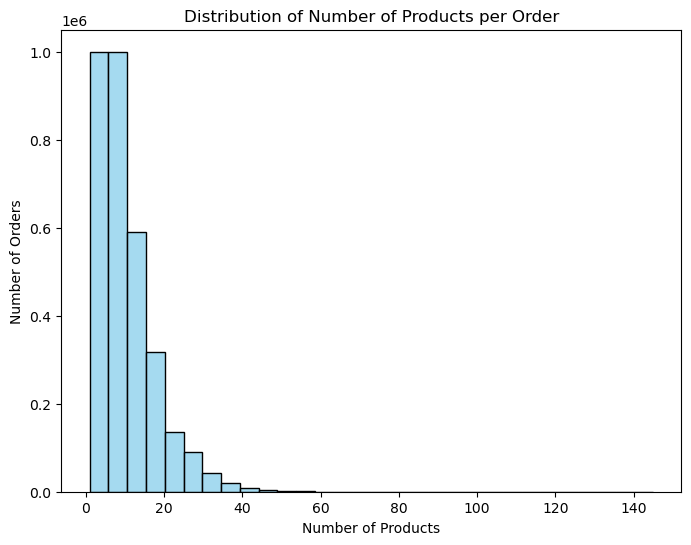

CPU times: user 2.28 s, sys: 184 ms, total: 2.47 s
Wall time: 2.33 s


In [111]:
%%time

products_per_order = df_0.groupby('order_id')['product_id'].count()

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.histplot(products_per_order, bins=30, color='skyblue',kde=False)
plt.title('Distribution of Number of Products per Order')
plt.xlabel('Number of Products')
plt.ylabel('Number of Orders')
plt.savefig('distri.png',transparent = 'True',bbox_inches='tight')
plt.show()

#### **(b)** User's Purchase History 

100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 163.54it/s]


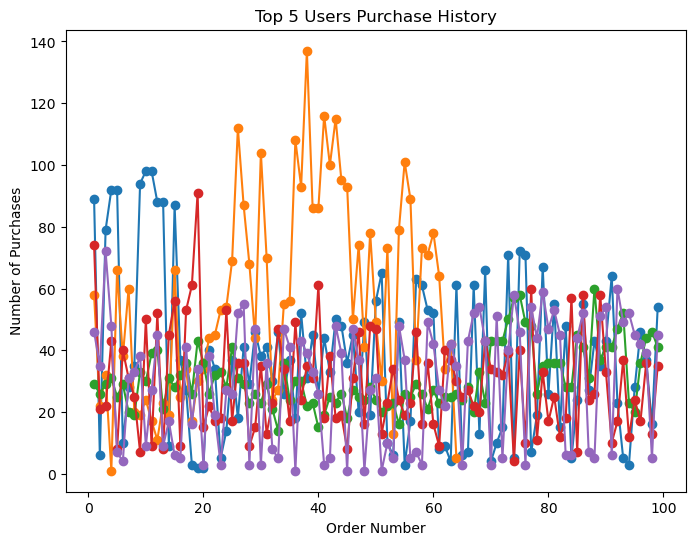

CPU times: user 2.61 s, sys: 473 ms, total: 3.09 s
Wall time: 2.18 s


In [92]:
%%time

user_purchases = df_0.groupby(['user_id', 'order_number']).size().reset_index(name='purchases')

top_users = user_purchases.groupby('user_id')['purchases'].sum().nlargest(5).index

plt.figure(figsize=(8, 6))
for user_id in tqdm(top_users):
    plt.plot(user_purchases[user_purchases['user_id'] == user_id]['order_number'], 
             user_purchases[user_purchases['user_id'] == user_id]['purchases'], marker='o')
plt.title('Top 5 Users Purchase History')
plt.xlabel('Order Number')
plt.ylabel('Number of Purchases')
plt.show()

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 102.36it/s]


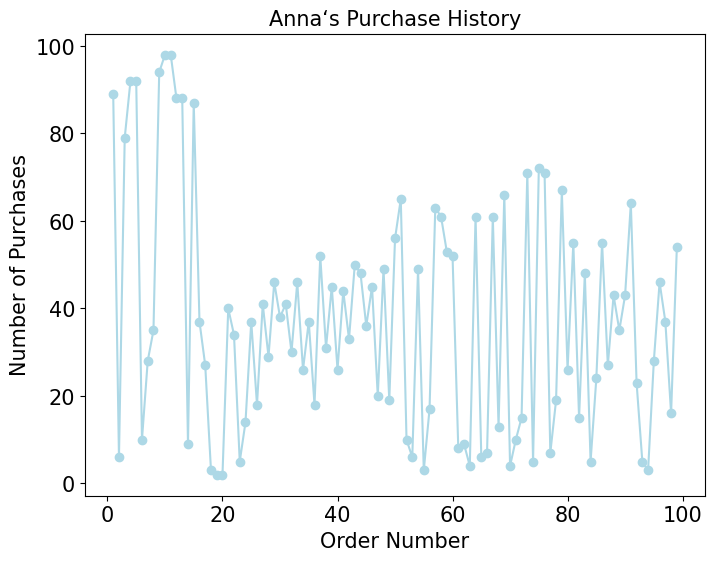

CPU times: user 2.38 s, sys: 259 ms, total: 2.64 s
Wall time: 2.05 s


In [93]:
%%time
## top user:Anna
user_purchases = df_0.groupby(['user_id', 'order_number']).size().reset_index(name='purchases')

top_users = user_purchases.groupby('user_id')['purchases'].sum().nlargest(1).index

plt.figure(figsize=(8, 6))
for user_id in tqdm(top_users):
    plt.plot(user_purchases[user_purchases['user_id'] == user_id]['order_number'], 
             user_purchases[user_purchases['user_id'] == user_id]['purchases'], marker='o', color='lightblue')
plt.title('Anna‘s Purchase History', fontsize=15)
plt.xlabel('Order Number',fontsize=15)
plt.ylabel('Number of Purchases',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig('anna.png',transparent = 'True',bbox_inches='tight')
plt.show()

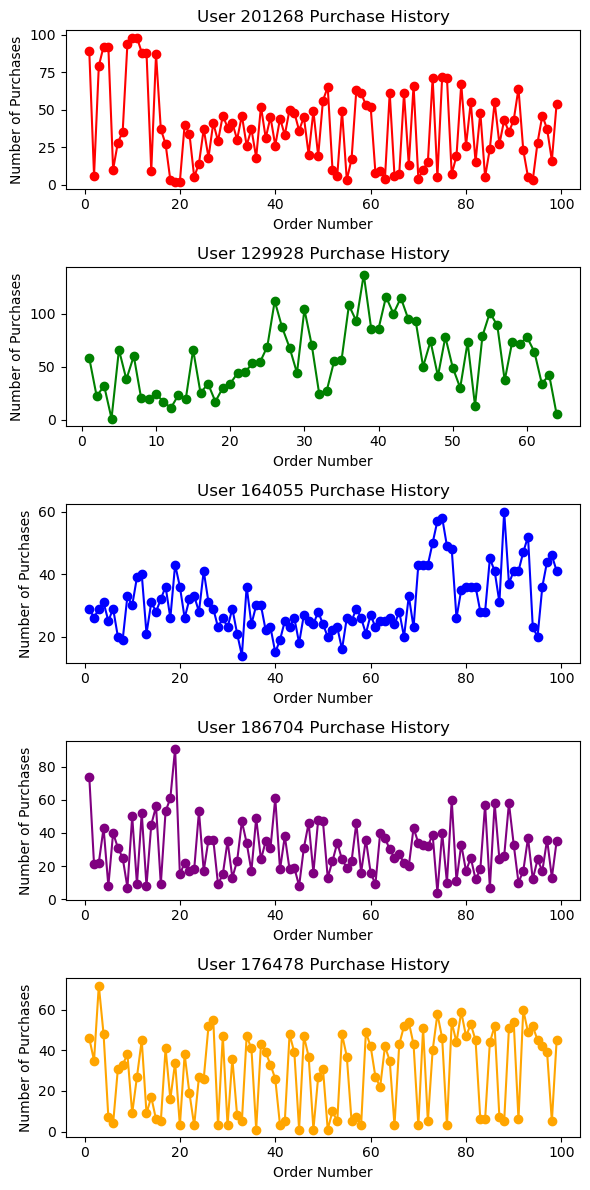

In [94]:
top_users = user_purchases.groupby('user_id')['purchases'].sum().nlargest(5).index

colors = ['red', 'green', 'blue', 'purple', 'orange']

fig, axs = plt.subplots(5, 1, figsize=(6, 12)) 

for i, user_id in enumerate(top_users):
    axs[i].plot(user_purchases[user_purchases['user_id'] == user_id]['order_number'], 
                user_purchases[user_purchases['user_id'] == user_id]['purchases'], 
                marker='o', color=colors[i])  # Assign color from the list
    axs[i].set_title(f'User {user_id} Purchase History')
    axs[i].set_xlabel('Order Number')
    axs[i].set_ylabel('Number of Purchases')

plt.tight_layout()
plt.show()

#### **(c)** When do people order?

Orders by Hour of the Day

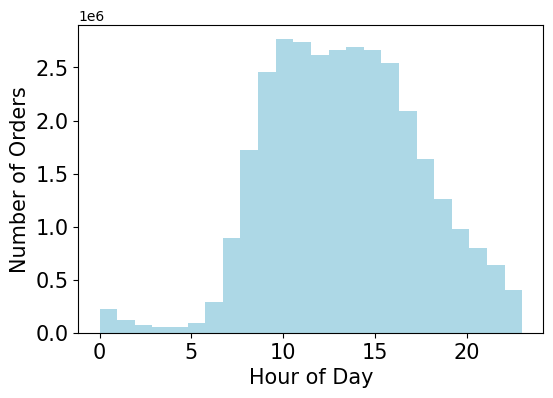

In [95]:
plt.figure(figsize=(6, 4))
plt.hist(df_0['order_hour_of_day'], bins=24, color='lightblue')
plt.xlabel('Hour of Day',fontsize=15)
plt.ylabel('Number of Orders',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('hour.png',transparent = 'True',bbox_inches='tight')
plt.show()

Orders by Day of the Week

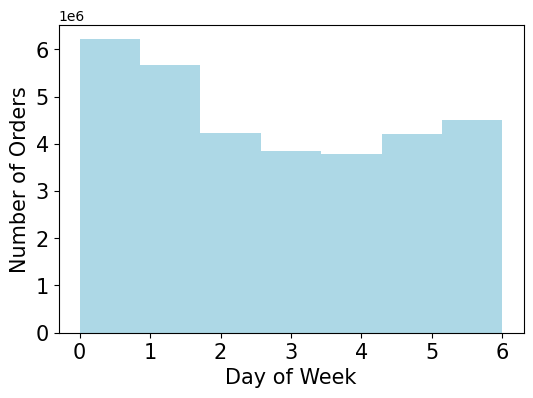

In [96]:
plt.figure(figsize=(6, 4))
plt.hist(df_0['order_dow'], bins=7, color='lightblue')
plt.xlabel('Day of Week',fontsize=15)
plt.ylabel('Number of Orders',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig('day.png',transparent = 'True',bbox_inches='tight')
plt.show()

Days Since the Prior Order

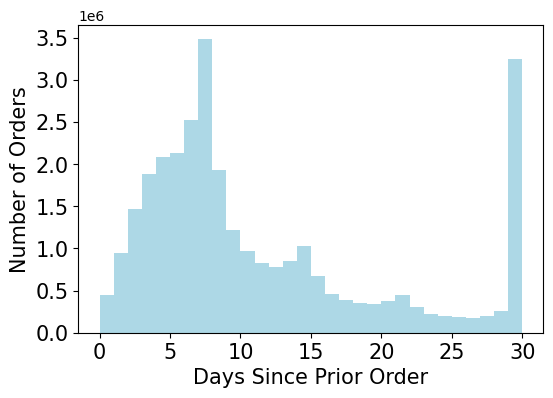

In [97]:
plt.figure(figsize=(6, 4))
plt.hist(df_0['days_since_prior_order'].dropna(), bins=30, color='lightblue')
plt.xlabel('Days Since Prior Order',fontsize=15)
plt.ylabel('Number of Orders',fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig('previous.png',transparent = 'True',bbox_inches='tight')
plt.show()

Order Counts by Order Number for Prior Orders

In [98]:
plt.figure(figsize=(6, 4))
prior_orders = df_0[df_0['eval_set'] == 'prior']
order_counts = prior_orders['order_number'].value_counts().sort_index()
plt.plot(order_counts.index, order_counts.values, color='red', linewidth=1)
plt.scatter(order_counts.index, order_counts.values, color='red', s=4)
plt.xlabel('Order Number')
plt.ylabel('Count')
plt.show()

Number of Items per Order

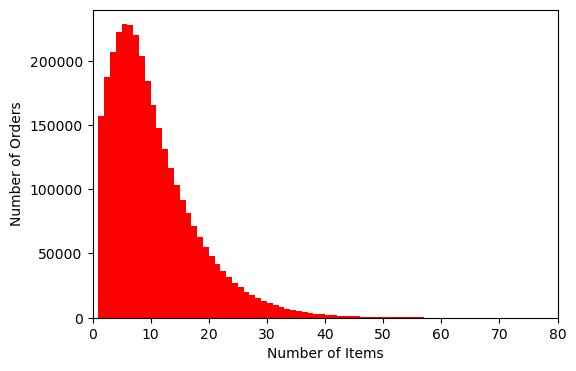

In [99]:
plt.figure(figsize=(6, 4))
order_size = df_0.groupby('order_id')['add_to_cart_order'].max()
plt.hist(order_size, bins=range(1, 81), color='red')
plt.xlabel('Number of Items')
plt.ylabel('Number of Orders')
plt.xlim(0, 80)
plt.show()

How Often do People Order the Same Items Again?

In [100]:
reorder_counts = df_0['reordered'].value_counts().reset_index()
reorder_counts.columns = ['reordered', 'count']
reorder_counts['proportion'] = reorder_counts['count'] / reorder_counts['count'].sum()
reorder_counts['reordered'] = reorder_counts['reordered'].astype(str)

print(reorder_counts)

  reordered     count  proportion
0         1  19126536    0.589697
1         0  13307953    0.410303


**59% of the Ordered Items are Reorders**

In [101]:
total_count = reorder_counts['count'].sum()

# Calculate the percentage for each category
reorder_counts['percentage'] = (reorder_counts['count'] / total_count) * 100

plt.figure(figsize=(6, 4))
plt.bar(reorder_counts['reordered'], reorder_counts['percentage'], color=['blue', 'red'], label=['Reordered', 'Not Reordered'])
plt.title("Ordered Items are Reorders")
plt.xlabel('Reordered')
plt.ylabel('Percentage')
plt.legend()  # This will add the legend to the plot
plt.show()

Most Often Reordered

In [102]:
# Group by 'product_id', calculate the mean and size of 'reordered', and filter by size > 40
product_reorder = df_0.groupby('product_id')['reordered'].agg(['mean', 'size'])
product_reorder = product_reorder[product_reorder['size'] > 40]

# Get the top 10 products by 'mean' and reset the index
top_products = product_reorder.nlargest(10, 'mean').reset_index()

# Merge with the original dataframe to get the product names
top_products = top_products.merge(df_0[['product_id', 'product_name']].drop_duplicates(), on='product_id')

# Print the resulting DataFrame
print(top_products)

   product_id      mean  size                              product_name
0        6433  0.941176    68                       Raw Veggie Wrappers
1        2075  0.931034    87  Serenity Ultimate Extrema Overnight Pads
2       27740  0.920792   101                        Chocolate Love Bar
3       13875  0.911111    45          Simply Sleep Nighttime Sleep Aid
4       31418  0.900000    60                            Sparking Water
5       35604  0.900000   100                           Maca Buttercups
6       36543  0.895522    67                        Bars Peanut Butter
7       26093  0.893939    66                 Soy Crisps Lightly Salted
8       38251  0.891892   111                     Benchbreak Chardonnay
9       36801  0.885417    96                  Organic Blueberry B Mega


## Top 10 Products Have Been Reordered

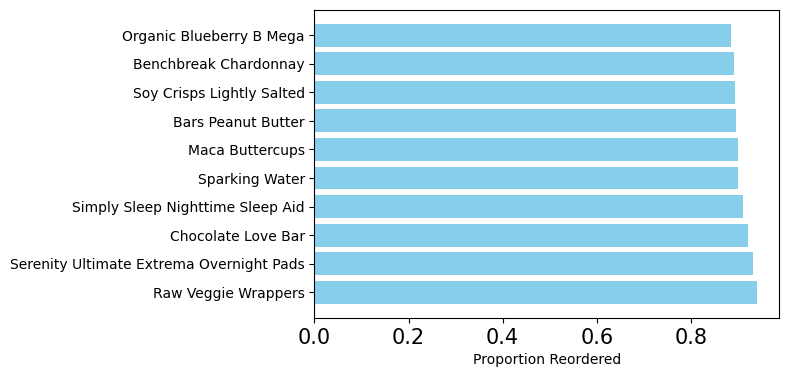

In [109]:
plt.figure(figsize=(6, 4))
#colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'brown', 'pink', 'gray', 'cyan']
plt.barh(top_products['product_name'], top_products['mean'], color='skyblue')
plt.title("Top 10 Products Have Been Reordered")
plt.xlabel('Proportion Reordered')
plt.xticks(fontsize=15)

plt.savefig('reorder.png',transparent = 'True',bbox_inches='tight')
plt.show()

Most Common First Item Added to the Cart

People seem to be quite certain about Multifold Towels and if they buy them, put them into their cart first in 66% of the time.

In [31]:
# Filter the DataFrame to include only the first items added to the cart
first_adds = df_0[df_0['add_to_cart_order'] == 1]

# Count the occurrences of each product_id and reset the index
# Use parallel_apply instead of value_counts to utilize multiple cores
first_adds_count = first_adds['product_id'].parallel_apply(lambda x: x).value_counts().reset_index()
first_adds_count.columns = ['product_id', 'count']

# Calculate the percentage of each product_id in the total count
first_adds_count['pct'] = first_adds_count['count'] / first_adds_count['count'].sum()

# Get the top 10 products by 'pct' and merge with the original DataFrame to get the product names
# Ensure that the product_name column is not duplicated before merging
df_0_unique_products = df_0[['product_id', 'product_name']].drop_duplicates()
top_first_adds = first_adds_count.nlargest(10, 'pct').merge(df_0_unique_products, on='product_id')

# Print the resulting DataFrame
print(top_first_adds)

   product_id   count       pct            product_name
0       24852  110916  0.034501                  Banana
1       13176   78988  0.024570  Bag of Organic Bananas
2       27845   30927  0.009620      Organic Whole Milk
3       21137   27975  0.008702    Organic Strawberries
4       47209   24116  0.007501    Organic Hass Avocado
5       21903   23543  0.007323    Organic Baby Spinach
6       47766   22398  0.006967         Organic Avocado
7       19660   16822  0.005233            Spring Water
8       16797   16366  0.005091            Strawberries
9       27966   14393  0.004477     Organic Raspberries


In [32]:
# Plot the resulting DataFrame
plt.figure(figsize=(6, 4))
plt.barh(top_first_adds['product_name'], top_first_adds['pct'], color='red')
plt.title("Most Common First Item Added to the Cart")
plt.xlabel('Percentage')
plt.show()

Association Between Time of Last Order and Probability of Reorder

We can see that if people order again on the same day, they order the same product more often. Whereas when 30 days have passed, they tend to try out new things in their order.

In [53]:
mean_reorder = df_0.groupby('days_since_prior_order')['reordered'].mean().reset_index()
plt.bar(mean_reorder['days_since_prior_order'], mean_reorder['reordered'], color='blue')
plt.xlabel('Days Since Prior Order')
plt.ylabel('Mean Reorder Rate')
plt.show()

Association Between Number of Orders and Probability of Reordering

Products with a high number of orders are naturally more likely to be reordered. However, there seems to be a ceiling effect.

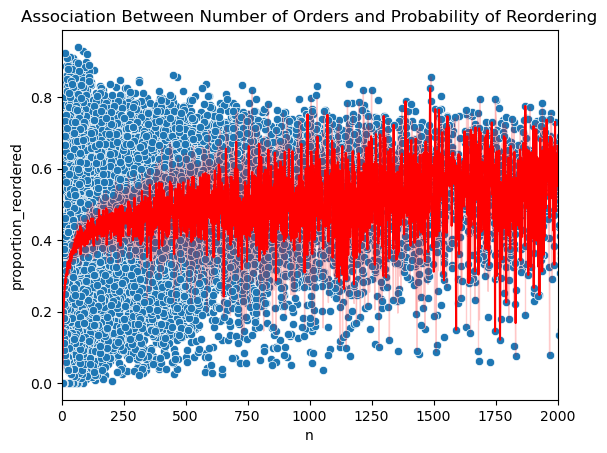

In [34]:
product_reorder = df_0.groupby('product_id')['reordered'].agg(['mean', 'size']).reset_index()
product_reorder.columns = ['product_id', 'proportion_reordered', 'n']
sns.scatterplot(data=product_reorder, x='n', y='proportion_reordered')
sns.lineplot(data=product_reorder, x='n', y='proportion_reordered', color='red')
plt.title("Association Between Number of Orders and Probability of Reordering")
plt.xlim(0, 2000)
plt.show()

### 2.2  Basket analysis

Top 10 Most Frequent Products

In [35]:
product_frequency = df_0['product_name'].value_counts()

# Plot the top 10 most frequent products
plt.figure(figsize=(8, 6))
sns.barplot(x=product_frequency[:10], y=product_frequency.index[:10], palette='pastel')
plt.title('Top 10 Most Frequent Products')
plt.xlabel('Frequency')
plt.ylabel('Product Name')
plt.show()

Organic vs Non-organic

What is the percentage of orders that are organic vs. not organic?

In [36]:
df_0['organic'] = df_0['product_name'].str.lower().apply(lambda x: 'organic' if 'organic' in x else 'not organic')
df_0['organic'] = df_0['organic'].astype('category')

org_tmp = df_0.groupby('organic').size().reset_index(name='count')
org_tmp['proportion'] = org_tmp['count'] / org_tmp['count'].sum()

print(org_tmp)

       organic     count  proportion
0  not organic  22183774    0.683956
1      organic  10250715    0.316044


In [37]:
sns.barplot(data=org_tmp, x='organic', y='count', hue='organic')
plt.title("Not Organic vs. Organic")
plt.show()

Reordering Organic vs Non-Organic

In [38]:
re_org_tmp = df_0.groupby('organic')['reordered'].mean().reset_index()
print(re_org_tmp)

       organic  reordered
0  not organic   0.568799
1      organic   0.634924


In [39]:
sns.barplot(data=re_org_tmp, x='organic', y='reordered', hue='organic')
plt.title("Reordering Organic vs. Non-Organic")
plt.show()

Visualizing the Product Portfolio

In [52]:
# Group by department_id and aisle_id and count the number of products
dep_ais_tmp = df_0.groupby(['department_id', 'aisle_id']).size().reset_index(name='n')
dep_ais_tmp = dep_ais_tmp.merge(df_0[['department_id', 'department']].drop_duplicates(), on='department_id')
dep_ais_tmp = dep_ais_tmp.merge(df_0[['aisle_id', 'aisle']].drop_duplicates(), on='aisle_id')

# Group by product_id and count, then join with df_0 and group again by department_id and aisle_id
pdt_id_tmp = df_0.groupby('product_id').size().reset_index(name='count')
pdt_id_tmp = pdt_id_tmp.merge(df_0[['product_id', 'department_id', 'aisle_id']].drop_duplicates(), on='product_id')
pdt_id_tmp = pdt_id_tmp.groupby(['department_id', 'aisle_id']).agg({'count': 'sum'}).reset_index()
pdt_id_tmp = pdt_id_tmp.merge(dep_ais_tmp, on=['department_id', 'aisle_id'])
pdt_id_tmp['onesize'] = 1

# Create treemap
fig = px.treemap(pdt_id_tmp, path=['department', 'aisle'], values='onesize', color='department')
fig.update_traces(marker=dict(colors=px.colors.qualitative.Set3), textfont=dict(size=18))

# Set the background to transparent
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)'
    #plot_bgcolor='rgba(0,0,0,0)'
)

# Save the figure as a PNG image with a transparent background
fig.write_image('treemap_chart.png', format='png')

fig.show()

### How many unique products are offered in each department/aisle?

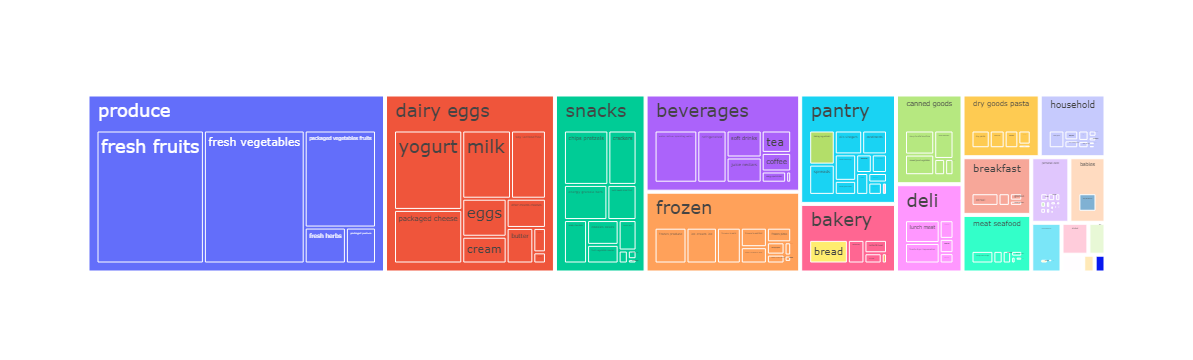

In [41]:
fig = px.treemap(dep_ais_tmp, path=['department', 'aisle'], values='n')
fig.update_traces(marker=dict(colors=px.colors.qualitative.Set3), textfont=dict(size=18))
fig.show()

### Customers reordering only

In [42]:
eval_tmp = df_0[df_0['eval_set'] == 'prior'].groupby('order_id').agg({'reordered': 'mean', 'product_id': 'size'}).reset_index()
eval_tmp.columns = ['order_id', 'm', 'n']
eval_tmp = eval_tmp.merge(df_0[df_0['order_number'] > 2], on='order_id')

# Group by user_id and calculate sum and percentage of reorders
user_tmp = eval_tmp.groupby('user_id').agg({'m': lambda x: (x == 1).sum(), 'n': 'size'})
user_tmp['percent_equal'] = user_tmp['m'] / user_tmp['n']
user_tmp = user_tmp[user_tmp['percent_equal'] == 1].sort_values(by='m', ascending=False).reset_index()

user_tmp

user_id    m    n  percent_equal
0       99753  187  187            1.0
1       55331  158  158            1.0
2      111365   81   81            1.0
3       74656   78   78            1.0
4       90796   63   63            1.0
...       ...  ...  ...            ...
3482   160798    1    1            1.0
3483    38200    1    1            1.0
3484   118194    1    1            1.0
3485   118125    1    1            1.0
3486    94960    1    1            1.0

[3487 rows x 4 columns]

Customer with the Strongest Habit

In [43]:
uniqueorders = eval_tmp[eval_tmp['user_id'] == 99753]['order_id']
id_tmp = df_0[df_0['order_id'].isin(uniqueorders)]

# Display the data
id_tmp.drop(columns=['aisle_id', 'department_id', 'organic'])

order_id  product_id  add_to_cart_order  reordered  \
4450282     46614       27845                  1          1   
4450283     46614       38689                  2          1   
4450509     67223       27845                  1          1   
4450510     67223       38689                  2          1   
4452287    214506       27845                  1          1   
...           ...         ...                ...        ...   
4490563   3359243       27845                  1          1   
4490564   3359243       38689                  2          1   
4640832    445207       38689                  1          1   
4641949   1917685       38689                  1          1   
4642679   2846923       38689                  1          1   

                     product_name  user_id eval_set  order_number  order_dow  \
4450282        Organic Whole Milk    99753    prior            45          3   
4450283  Organic Reduced Fat Milk    99753    prior            45          3   
4450509        Organic Whole Milk    99753    prior            65          4   
4450510  Organic Reduced Fat Milk    99753    prior            65          4   
4452287        Organic Whole Milk    99753    prior            36          1   
...                           ...      ...      ...           ...        ...   
4490563        Organic Whole Milk    99753    prior            10          1   
4490564  Organic Reduced Fat Milk    99753    prior            10          1   
4640832  Organic Reduced Fat Milk    99753    prior            28          1   
4641949  Organic Reduced Fat Milk    99753    prior            21          4   
4642679  Organic Reduced Fat Milk    99753    prior            38          1   

         order_hour_of_day  days_since_prior_order aisle  department  
4450282                  7                     2.0  milk  dairy eggs  
4450283                  7                     2.0  milk  dairy eggs  
4450509                 12                     2.0  milk  dairy eggs  
4450510                 12                     2.0  milk  dairy eggs  
4452287                  8                     5.0  milk  dairy eggs  
...                    ...                     ...   ...         ...  
4490563                 10                     4.0  milk  dairy eggs  
4490564                 10                     4.0  milk  dairy eggs  
4640832                 12                     3.0  milk  dairy eggs  
4641949                 10                     2.0  milk  dairy eggs  
4642679                  8                     4.0  milk  dairy eggs  

[187 rows x 13 columns]

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#!pip install squarify
import squarify



# Assuming df_0 is your initial DataFrame with the columns as specified

# Step 1: Group by department_id and aisle_id, and count the number of products for each combination
department_counts = (df_0.groupby(['department_id', 'aisle_id', 'department', 'aisle'])
                        .size()
                        .reset_index(name='product_count'))

# Step 2: Sort the grouped data by department_id to group the departments together in the treemap
department_counts.sort_values(by=['department_id', 'aisle_id'], inplace=True)

# Step 3: Assign a unique color to each department
unique_departments = department_counts['department'].unique()
colors_palette = plt.cm.get_cmap('tab20', len(unique_departments))
department_to_color = {dept: colors_palette(i) for i, dept in enumerate(unique_departments)}
colors = department_counts['department'].map(department_to_color)

# Define sizes and labels for the treemap
sizes = department_counts['product_count']
#labels = department_counts.apply(lambda x: f"{x['aisle']}", axis=1)  # Only aisle names on treemap for clarity

# Create the treemap
fig, ax = plt.subplots(figsize=(12, 8))
squarify.plot(sizes=sizes, color=colors, alpha=0.8, edgecolor="#FFFFFF", ax=ax)

# Create a legend for departments
patches = [mpatches.Patch(color=color, label=department) for department, color in department_to_color.items()]
plt.legend(handles=patches, title='Departments', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

# Additional customizations
plt.title("Treemap by Department and Aisle")
ax.axis('off')  # Remove axes

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()


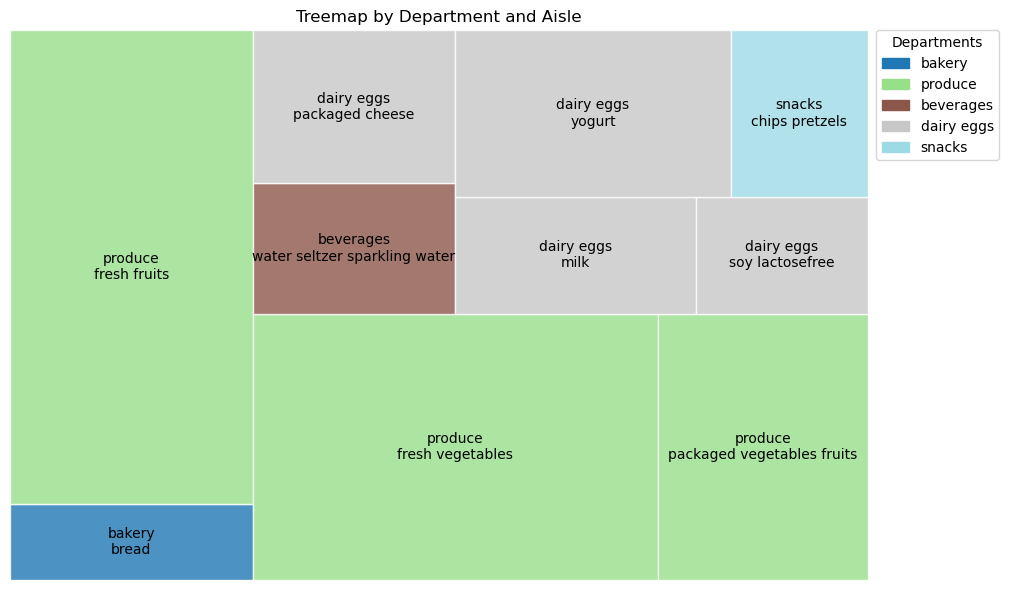

In [46]:

# Assuming df_0 is your initial DataFrame with the columns as specified

# Step 1: Group by department_id and aisle_id, and count the number of products for each combination
department_counts = (df_0.groupby(['department_id', 'aisle_id', 'department', 'aisle'])
                        .size()
                        .reset_index(name='product_count')
                        .nlargest(10, 'product_count'))

# Step 2: Sort the grouped data by department_id to group the departments together in the treemap
department_counts.sort_values(by=['department_id', 'aisle_id'], inplace=True)

# Step 3: Assign a unique color to each department
unique_departments = department_counts['department'].unique()
colors_palette = plt.cm.get_cmap('tab20', len(unique_departments))
department_to_color = {dept: colors_palette(i) for i, dept in enumerate(unique_departments)}
colors = department_counts['department'].map(department_to_color)

# Define sizes and labels for the treemap
sizes = department_counts['product_count']
labels = department_counts.apply(lambda x: f"{x['department']}\n{x['aisle']}", axis=1)  # Only aisle names on treemap for clarity

# Create the treemap
fig, ax = plt.subplots(figsize=(12, 6))
squarify.plot(sizes=sizes, label=labels,color=colors, alpha=0.8, edgecolor="#FFFFFF", ax=ax)

# Create a legend for departments
patches = [mpatches.Patch(color=color, label=department) for department, color in department_to_color.items()]
plt.legend(handles=patches, title='Departments', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

# Additional customizations
plt.title("Treemap by Department and Aisle")
ax.axis('off')  # Remove axes

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()


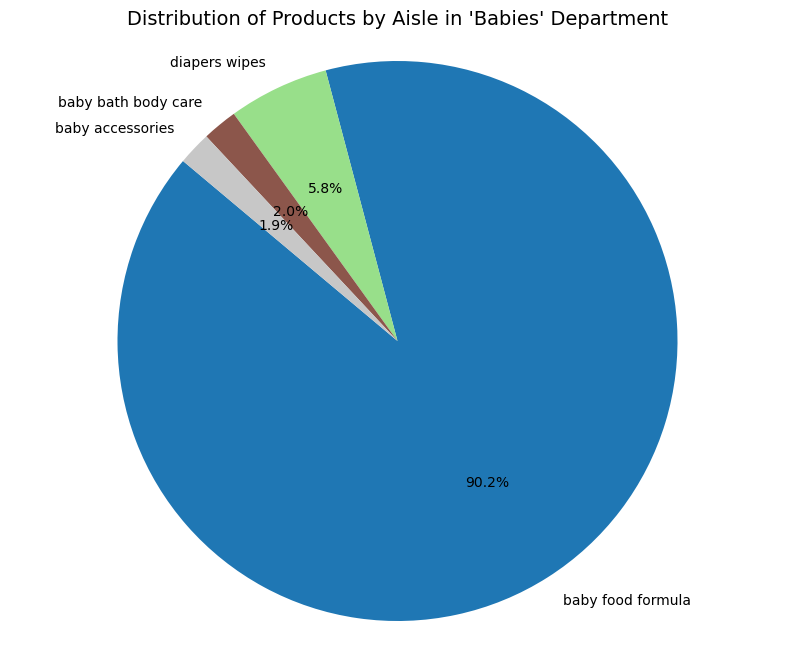

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_0 is your initial DataFrame with the columns as specified

# Filter the DataFrame for the department 'babies'
babies_department_df = df_0[df_0['department'] == 'babies']

# Group by aisle and sum the count of products for each aisle within the 'babies' department
aisle_counts = (babies_department_df.groupby(['aisle'])
                .size()
                .reset_index(name='count'))

# Sort the grouped data by count in descending order (optional)
aisle_counts.sort_values(by='count', ascending=False, inplace=True)

# Prepare data for the pie chart
sizes = aisle_counts['count']
labels = aisle_counts['aisle']

# Create the pie chart
plt.figure(figsize=(10, 8),facecolor = 'none')
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=[colors_palette(i) for i in range(len(labels))])
plt.title("Distribution of Products by Aisle in 'Babies' Department", fontsize=14)

# Additional customizations
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('pie.png',transparent = 'True',bbox_inches='tight')
plt.show()


In [49]:
import matplotlib.pyplot as plt

# Assuming aisle_counts is your DataFrame ready for plotting

# Prepare data for the pie chart
sizes = aisle_counts['count']
labels = aisle_counts['aisle']

# Define a function to format the percentage text
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%'.format(p=pct) if pct > 0 else ''
    return my_format

# Adjust figure size as needed
plt.figure(figsize=(10, 8))

# Create the pie chart with percentages inside the slices
wedges, texts, autotexts = plt.pie(sizes, labels=None, autopct=autopct_format(sizes),
                                   startangle=140, pctdistance=0.75,
                                   colors=[plt.cm.tab20(i/float(len(labels))) for i in range(len(labels))])

# Adjust legend to be closer to the pie
plt.legend(wedges, labels, title="Aisles", loc="center left", bbox_to_anchor=(0.85, 0.5, 0.5, 1),
           fontsize='large')

#plt.title("Distribution of Products by Aisle in 'Babies' Department", fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Optionally increase percentage label size
plt.setp(autotexts, size=10, weight="bold")

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the right side of the rect to make more room for the legend
plt.savefig('pie_chart_with_legend_closer.png', transparent=True, bbox_inches='tight')
plt.show()


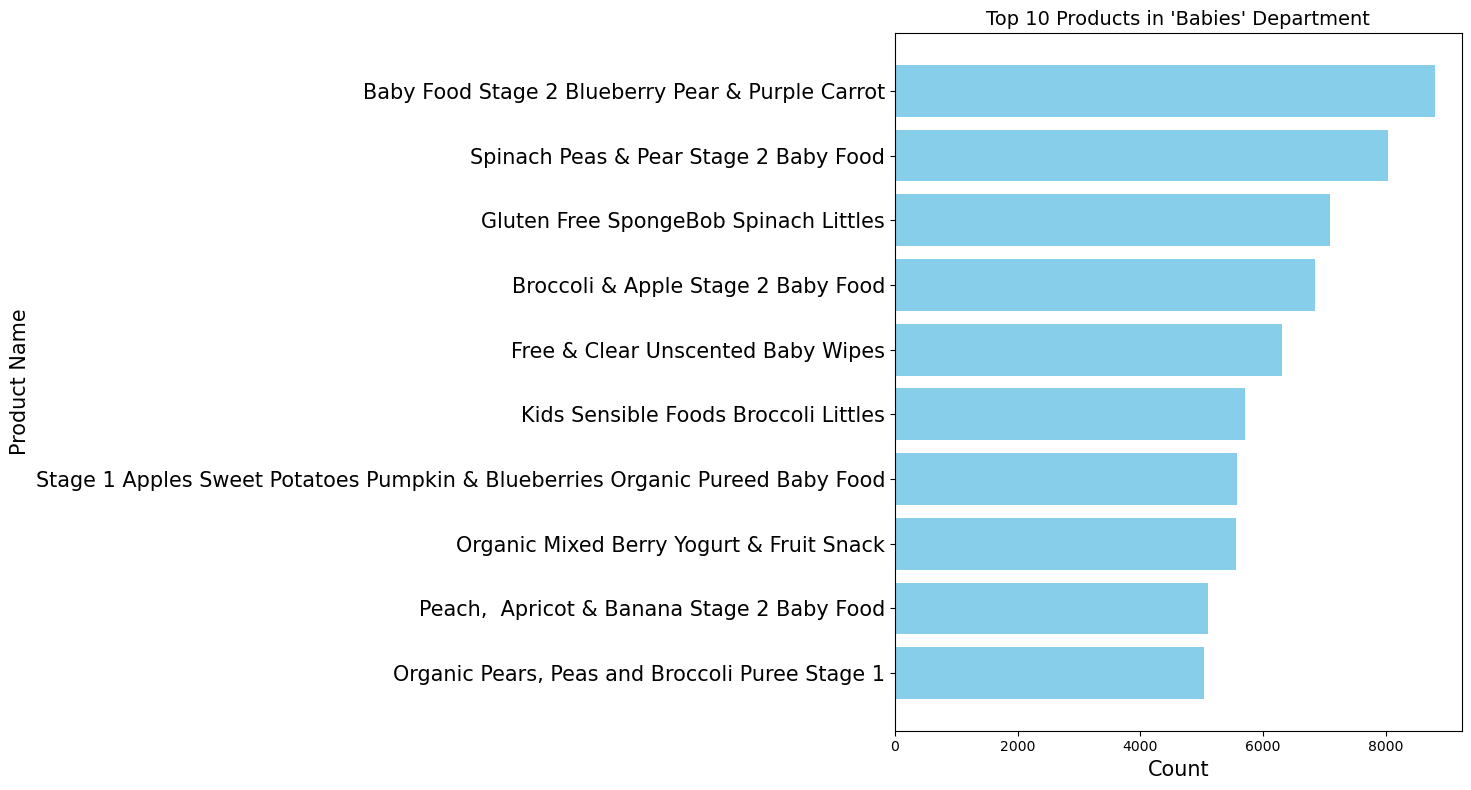

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_0 is your initial DataFrame with the columns as specified

# Filter the DataFrame for the department 'babies'
babies_department_df = df_0[df_0['department'] == 'babies']

# Group by product_name, and count the number of occurrences for each product within the 'babies' department
product_counts = (babies_department_df.groupby(['product_name'])
                                       .size()
                                       .reset_index(name='count'))

# Sort the grouped data by count in descending order and select the top 15
top_products = product_counts.sort_values(by='count', ascending=False).head(10)

# Create the bar chart
plt.figure(figsize=(12, 8),facecolor = 'none')
plt.barh(top_products['product_name'], top_products['count'], color='skyblue')
plt.xlabel('Count', fontsize=15)
plt.ylabel('Product Name', fontsize=15)
plt.title("Top 10 Products in 'Babies' Department", fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to have the product with the highest count on top
plt.tight_layout()  # Adjust layout to make room for all elements
plt.yticks(fontsize=15)
plt.savefig('top15.png',transparent = 'True',bbox_inches='tight')
plt.show()
